In [1]:
import networkx
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy

In [2]:
### experiment variables 

# if downloading from graphlearning.io, they all have same filesystems (I hope)
# ex. IMDB-BINARY, NCI1, AIDS
prefix = "IMDB-BINARY"

# exclude graphs greater than a certain size
max_size = 40
###

In [3]:
with open("{}_A.txt".format(prefix, prefix), "r") as f:
    edges = [list(map(int, line.strip().split(','))) for line in f.readlines()]

graph_n = defaultdict(set)
with open("{}_graph_indicator.txt".format(prefix, prefix), "r") as f:
    lines = [int(line.strip()) for line in f.readlines()]
    for node, g in enumerate(lines):
        graph_n[g-1].add(node+1)
    
with open("{}_graph_labels.txt".format(prefix, prefix), "r") as f:
    graph_c = np.array([int(line.strip()) for line in f.readlines()])
    
graphs = defaultdict(set)
current = 0
for edge in edges:
    if edge[0] not in graph_n[current]:
        current += 1
    graphs[current].add((edge[0], edge[1]))

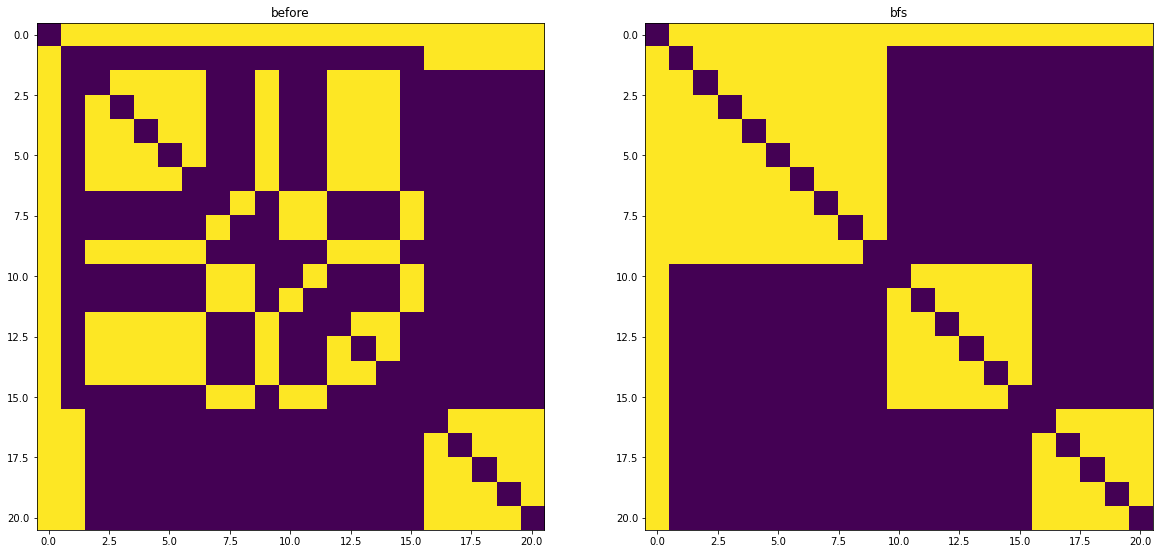

In [33]:
def bfs_ordering(graph, plot=False):
    '''
    creates the A matrix from the input edges
    '''
    ### preprocessing
    G = networkx.Graph()
    G.add_edges_from(list(graph))
    G.to_undirected()
    degrees = dict(G.degree())
#     print(degrees)
    low_v = min(list(degrees.items()), key=lambda item:item[0])[0]
    high_v = max(list(degrees.items()), key=lambda item:item[0])[0]
#     print(index, low_v, high_v)
    graph_bfs = {}
    zero = []
    for idx in range(low_v, high_v+1):
        neighbors = []
        try:
            G[idx]
        except KeyError:
            print(idx)
            zero.append(idx)
        for neighbor in G[idx]:
            neighbors.append((neighbor, degrees[neighbor]))
        neighbors = [n[0] for n in sorted(neighbors, key=lambda item: item[1], reverse=True)]
        graph_bfs[idx] = neighbors
    ### bfs algorithm
    order = []

    start = max(list(degrees.items()), key=lambda item:item[1])[0]
#     print(start)
    visited = [False] * (high_v+1)
    
    queue = []
 
    queue.append(start)
    visited[start] = True
    
    while queue:
        s = queue.pop(0)
        order.append(s)

        for i in graph_bfs[s]:
            if visited[i] == False:
                queue.append(i)
                visited[i] = True
    order.extend(zero)      
    A = networkx.to_numpy_array(G, nodelist=order)
    
    if plot:
        A2 = networkx.to_numpy_array(G)
        plt.figure(figsize=(20,15))
        plt.subplot(121)
        plt.title('before')
        plt.imshow(A2)
        plt.subplot(122)
        plt.title('bfs')
        plt.imshow(A)
        plt.show()
    return A

A = bfs_ordering(graphs[2], True)

In [34]:
def get_C(chars):
    chars1 = []

    for idx, poly in enumerate(chars):
        if len(poly) == max_size:
            chars1.append(c1)
            continue
        c1 = np.pad(poly, (0, max(0, max_size - len(poly)+1)), mode='constant')
        chars1.append(c1)

    chars1 = np.stack(chars1, axis=0)
    chars1 = np.real(chars1)

    return chars1

In [35]:
def process_graphs(graphs, bfs=False):
    As = []
    Ms = []
    chars = []
    labels = []

    for idx, graph in enumerate(graphs.values()):
        if bfs:
            A = bfs_ordering(graph)
        else:
            G = networkx.Graph()
            G.add_edges_from(list(graph))
            G.to_undirected
            A = networkx.to_numpy_array(G)
        if len(A) > max_size:
            continue

        As.append(A)
        w, v = scipy.linalg.eig(A)
        gft_1 = v/np.linalg.norm(v, axis=1)
        gft = gft_1.T
        lambda_star = np.matrix.conjugate(np.diag(w))
        M = gft@lambda_star@gft_1
        Ms.append(np.abs(M))
        char = np.poly(A)
        chars.append(char)
        labels.append(graph_c[idx])
    
    c_polys = get_C(chars)

    return As, Ms, c_polys, labels
        
As_bfs, Ms_bfs, c_polys_bfs, labels_bfs = process_graphs(graphs, True)
As, Ms, c_polys, labels = process_graphs(graphs, False)


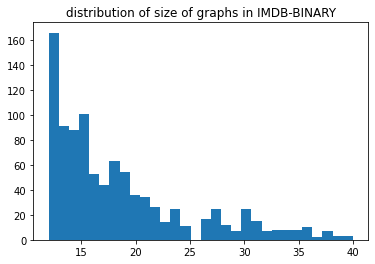

In [36]:
# basically just pad with zeros, and then shove it into the svm

def graph_size_dist(As):
    graph_sizes = [len(A) for A in As]
    plt.hist(graph_sizes, 30)
    plt.title('distribution of size of graphs in {}'.format(prefix))
    plt.show()

graph_size_dist(As)

def reshape(mats, max_size=max_size):
    new_mats = []

    for idx, mat in enumerate(mats):
        mat_len = mat.shape[0]
        pad_len = (0, max_size - mat_len)
        mat_size = [1, max_size ** 2]
        padded = np.pad(mat, [pad_len, pad_len], mode='constant')
        new_mats.append(np.resize(padded, mat_size))
    
    new_mats = np.squeeze(np.array(new_mats))

    return new_mats

As = reshape(As, max_size)
Ms = reshape(Ms, max_size)

As_bfs = reshape(As_bfs, max_size)
Ms_bfs = reshape(Ms_bfs, max_size)


In [37]:
import numpy as np
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RF

class CLF:
    def __init__(self, clf_type):
        clf = None
        if clf_type == 'LR':
            clf = LR(solver='liblinear')
        elif clf_type == 'SVM':
            clf = SVC(gamma='auto', kernel='rbf')
        elif clf_type == 'RF':
            clf = RF(n_estimators=50)
        else:
            raise TypeError

        self.pipeline = make_pipeline(StandardScaler(), clf)

    def eval(self, data, labels, cv):
        scores = cross_val_score(self.pipeline, data, labels, cv=cv)
        return scores
    

In [38]:
from sklearn.model_selection import ShuffleSplit 

def evaluate_methods(A_graphs, M_graphs, c_polys, labels):
    clf_types = ['SVM']
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=20)

    scores = {}

    for clf_type in clf_types:
        print(clf_type)
        clf_A = CLF(clf_type)
        clf_M = CLF(clf_type)
        clf_C = CLF(clf_type)
        A_scores = clf_A.eval(A_graphs, labels, cv)
        M_scores = clf_M.eval(np.abs(M_graphs), labels, cv)
        C_scores = clf_C.eval(c_polys, labels, cv)
        scores[clf_type] = {}
        scores[clf_type]['A'] = np.mean(A_scores)
        scores[clf_type]['M'] = np.mean(M_scores)
        scores[clf_type]['C'] = np.mean(C_scores)

    return scores

In [31]:
scores = evaluate_methods(As, Ms, c_polys, labels)
scores

SVM


{'SVM': {'A': 0.6311418685121107,
  'M': 0.560553633217993,
  'C': 0.5833910034602077}}

In [32]:
scores_bfs = evaluate_methods(As_bfs, Ms_bfs, c_polys_bfs, labels_bfs)
scores_bfs

SVM


{'SVM': {'A': 0.6705882352941177,
  'M': 0.5937716262975778,
  'C': 0.5930795847750865}}